In [51]:
%pip install jax 
%pip install numpy
%pip install matplotlib
%pip install moviepy
%pip install proglog
%pip install flax
%pip install optax
%pip install ipykernel

/Users/aiueo/anaconda3/envs/ML/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [52]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import jax.random as random
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

#version更新によって削除されている
#from jax.experimental import stax
from flax import linen as nn
#from jax.experimental import optimizers
import optax

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

In [53]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
    t1, t2 = q #theta
    w1, w2 = q_dot #omega
    
    #Kinetic energy
    T1 = 0.5 * m1 * (l1 * w1)**2
    T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 + 2*l1*l2*w1*w2*jnp.cos(t1-t2))
    T= T1 + T2
    
    #Potential energy
    y1 = -l1 * jnp.cos(t1)
    y2 = y1 - l2 * jnp.cos(t2)
    V = m1 * g * y1 + m2 * g * y2
    
    return T - V

In [54]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
    t1, t2, w1, w2 = state
    a1 = (l2 / l1) * (m2/(m1 + m2)) * jnp.cos(t1 - t2)
    a2 = (l1 / l2) * jnp.cos(t1 - t2)
    f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - (g / l1) * jnp.sin(t1)
    f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2)- (g / l2) * jnp.sin(t2)
    g1 = (f1 - a1 * f2) / (1 - a1 * a2)
    g2 = (f2 - a2 * f1) / (1 - a1 * a2) 
    return jnp.stack([w1, w2, g1, g2])

In [55]:
def equation_of_motion(lagarangian, state, t=None):
    q, q_t = jnp.split(state, 2)
    #hessian, jacobianではlagrangianの仮引数の位置にある変数で演算を行う
    q_tt = (jnp.linalg.pinv(jax.hessian(lagarangian, 1)(q, q_t)) #逆行列部分の計算
            @(jax.grad(lagarangian, 0)(q, q_t) #[]内1項目
            - jax.jacobian(jax.jacobian(lagarangian, 1), 0)(q, q_t) @ q_t)) #[]内2項目, jax.jacobian(lagarangian, 1)は速度偏微分のベクトル
    return jnp.concatenate([q_t, q_tt]) #ベクトルを縦方向に結合

In [56]:
def solve_lagrangian(lagrangian, initial_state, **kwargs):
    @partial(jax.jit, backend='cpu')
    #
    def f(initial_state):
        #時間発展を計算
        return odeint(partial(equation_of_motion, lagrangian), #lagrangianを固定してequation_of_motionを定義し直す
                      initial_state, **kwargs)
    return f(initial_state) #q, q_tの時系列データ

In [57]:
# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

#時間発展における1ステップ先の状態を返す
def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [58]:
#choose an initial state
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
noise = np.random.RandomState(0).randn(x0.size)
t = np.linspace(0, 40, num = 401, dtype=np.float32)

In [59]:
#compute dynamics analytically
%time x_analytical = jax.device_get(solve_analytical(x0, t))
#ノイズを与えたときの変化がどうなるのか
noise_coeff_1, noise_coeff_2 = 1e-10, 1e-11
x_perturbed_1 = jax.device_get(solve_analytical(x0 + noise_coeff_1 * noise, t))
x_perturbed_2 = jax.device_get(solve_analytical(x0 + noise_coeff_2 * noise, t))

CPU times: user 711 ms, sys: 203 ms, total: 914 ms
Wall time: 596 ms


In [60]:
# compute dynamics via autograd / the rewritten E-L equation
%time x_autograd = jax.device_get(solve_autograd(x0, t))

CPU times: user 3.73 s, sys: 83.5 ms, total: 3.81 s
Wall time: 3.22 s


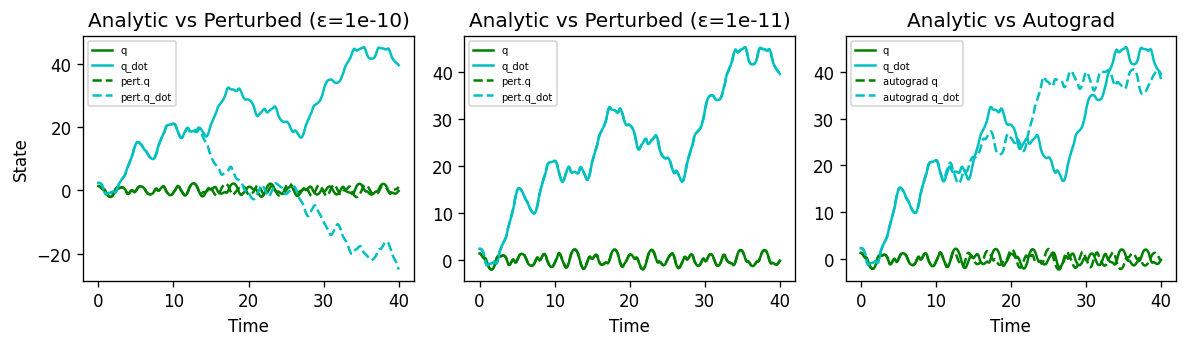

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=120)
(ax1, ax2, ax3) = axes

# === 1 ===
ax1.set_title("Analytic vs Perturbed (ε=1e-10)")
ax1.plot(t, x_analytical[:, 0], 'g-', label='q')
ax1.plot(t, x_analytical[:, 1], 'c-', label='q_dot')
ax1.plot(t, x_perturbed_1[:, 0], 'g--', label='pert.q')
ax1.plot(t, x_perturbed_1[:, 1], 'c--', label='pert.q_dot')
ax1.set_xlabel("Time")
ax1.set_ylabel("State")
ax1.legend(fontsize=6)

# === 2 ===
ax2.set_title("Analytic vs Perturbed (ε=1e-11)")
ax2.plot(t, x_analytical[:, 0], 'g-', label='q')
ax2.plot(t, x_analytical[:, 1], 'c-', label='q_dot')
ax2.plot(t, x_perturbed_2[:, 0], 'g--', label='pert.q')
ax2.plot(t, x_perturbed_2[:, 1], 'c--', label='pert.q_dot')
ax2.set_xlabel("Time")
ax2.legend(fontsize=6)

# === 3 ===
ax3.set_title("Analytic vs Autograd")
ax3.plot(t, x_analytical[:, 0], 'g-', label='q')
ax3.plot(t, x_analytical[:, 1], 'c-', label='q_dot')
ax3.plot(t, x_autograd[:, 0], 'g--', label='autograd q')
ax3.plot(t, x_autograd[:, 1], 'c--', label='autograd q_dot')
ax3.set_xlabel("Time")
ax3.legend(fontsize=6)

plt.tight_layout()
plt.show()
#はじめの方で予測できていればそれで良い(なぜなら摂動によるゆらぎがものすごいから)
#摂動による外部的なゆらぎと、autogradのズレという内部的な要因が同じ不安定性に基づいていることを示している

In [62]:
time_step = 0.01
N = 1500
#x以外を固定する。また解析解は時間に依存していない(状態を時間発展)、またvmapにより各状態xから次の状態yを並列計算するための関数
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

# x0 = np.array([-0.3*np.pi, 0.2*np.pi, 0.35*np.pi, 0.5*np.pi], dtype=np.float32)
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t = np.arange(N, dtype=np.float32) # time steps 0 to N

%time x_train = jax.device_get(solve_analytical(x0, t)) # dynamics for first N time steps, 時間発展の微分方程式を解くことで、各時刻の状態ベクトルを格納
%time xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) # time derivatives of each state, state(x)の時間微分を計算している
%time y_train = jax.device_get(analytical_step(x_train)) # analytical next step, ある状態から次の位置をRK4法を用いて並列計算で求める

noise = np.random.RandomState(0).randn(x0.size)
t_test = np.arange(N, 2*N, dtype=np.float32) # time steps N to 2N
%time x_test = jax.device_get(solve_analytical(x0, t_test)) # dynamics for next N time steps
%time xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) # time derivatives of each state
%time y_test = jax.device_get(analytical_step(x_test)) # analytical next step


CPU times: user 6.33 s, sys: 57.6 ms, total: 6.39 s
Wall time: 6.06 s
CPU times: user 9.48 ms, sys: 862 μs, total: 10.3 ms
Wall time: 10.2 ms
CPU times: user 187 ms, sys: 4.21 ms, total: 191 ms
Wall time: 132 ms
CPU times: user 5.55 s, sys: 25.6 ms, total: 5.57 s
Wall time: 5.62 s
CPU times: user 9.8 ms, sys: 2.72 ms, total: 12.5 ms
Wall time: 11.7 ms
CPU times: user 599 μs, sys: 92 μs, total: 691 μs
Wall time: 622 μs


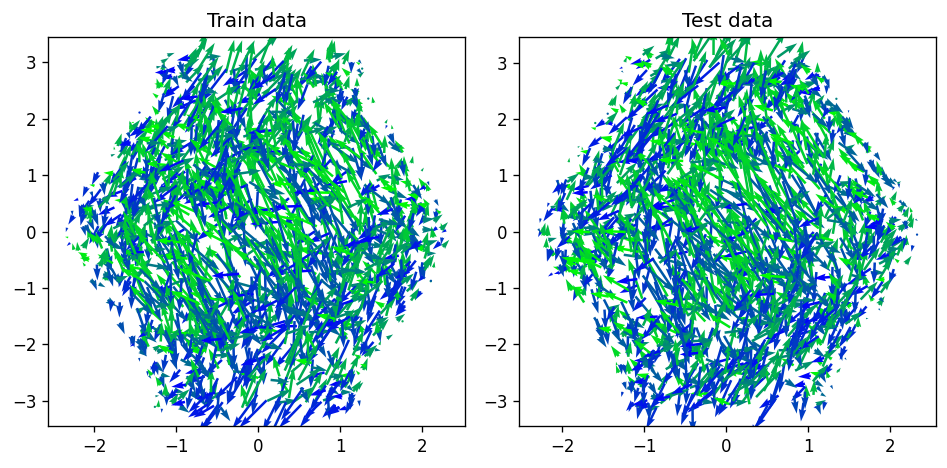

In [63]:
# preprocess, 状態を正規化している。特にθについて
train_vis = jax.vmap(normalize_dp)(x_train)
test_vis = jax.vmap(normalize_dp)(x_test)

vel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1)/2 #方向ベクトルの角度を[0, 1]に変換している
vel_color = lambda vangle: np.stack( [np.zeros_like(vangle), vangle, 1-vangle]).T #RGB, R=0, [3, N]→[N, 3]に転置している
train_colors = vel_color(vel_angle(train_vis)) #vel_angleという無名関数にtrain_visを渡して規格化した角度を渡す→それをもとに色に変換
test_colors = vel_color(vel_angle(test_vis))

# plot
SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Train data") ; plt.xlabel(r'') ; plt.ylabel(r'')
plt.quiver(*train_vis.T, color=train_colors, scale=SCALE, width=WIDTH)

plt.subplot(1,2,2)
plt.title("Test data") ; plt.xlabel(r'') ; plt.ylabel(r'')
plt.quiver(*test_vis.T, color=test_colors, scale=SCALE, width=WIDTH)

plt.tight_layout() ; plt.show()

In [73]:
#LNNモデルと損失関数を構築
def learned_lagrangian(params):
    def lagrangian(q, q_t):
        assert q.shape == (2, ) #形が[1, 2]であるかを確認。でなければエラーになる
        state = normalize_dp(jnp.concatenate([q, q_t])) #concatenateで一つのベクトルにする, normalize_dpで角度をスケーリング
        return jnp.squeeze(nn_forward_fn(params, state), axis=-1) #nn_forward_fnはNN順伝播関数, squeezeはサイズ1の次元を削除
    return lagrangian

@jax.jit
def loss(params, batch, time_step=None):
    state, targets = batch
    #time_stepがあるときは[t1, t2, w1, w2]そのものを予測する
    #ないときは、これらの時間微分を求める
    if time_step is not None:
        f = partial(equation_of_motion, learned_lagrangian(params))
        preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
    else:
        preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
    return jnp.mean((preds - targets)**2)

class LNNModel(nn.Module):
    hidden_dim: int = 128
    @nn.compact #__call__の中でレイヤーを定義するため
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim)(x) #全結合層
        x = nn.softplus(x) #活性化関数
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.softplus(x)
        x = nn.Dense(1)(x)
        return x

# モデル構築
model = LNNModel(hidden_dim=128)
params = model.init(random.PRNGKey(0), jnp.ones((1, 4)))

# 使い方（staxと同様に）
nn_forward_fn = lambda params, x: model.apply(params, x)

In [74]:
# オプティマイザ定義
optimizer = optax.adam(learning_rate=1e-3)  # 例としてAdamを使用
opt_state = optimizer.init(params)  # paramsは初期パラメータ

# timestep用更新関数
@jax.jit
def update_timestep(params, opt_state, batch, time_step):
    grads = jax.grad(loss)(params, batch, time_step)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# derivative用更新関数
@jax.jit
def update_derivative(params, opt_state, batch):
    grads = jax.grad(loss)(params, batch, None)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# データをGPU/TPUに転送して正規化
x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
y_train = jax.device_put(y_train)

x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
y_test = jax.device_put(y_test)

In [75]:
# 初期パラメータ生成
rng = jax.random.PRNGKey(0)
dummy_input = jnp.ones((1, 4))       # 入力次元に合わせる
init_params = model.init(rng, dummy_input)

# バッチ設定
batch_size = 100
test_every = 10
num_batches = 1500

train_losses = []
test_losses = []

# 学習率スケジュール (元の jnp.select の代替)
boundaries = [batch_size * (num_batches // 3), batch_size * (2 * num_batches // 3)]
values = [1e-3, 3e-4, 1e-4]
schedule = optax.piecewise_constant_schedule(init_value=1e-3, boundaries_and_scales={
    boundaries[0]: values[1]/values[0],
    boundaries[1]: values[2]/values[1]
})

# Adamオプティマイザ
optimizer = optax.adam(schedule)
opt_state = optimizer.init(init_params)

# 更新関数
@jax.jit
def update_derivative(params, opt_state, batch):
    grads = jax.grad(loss)(params, batch, None)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# トレーニングループ
params = init_params
for iteration in range(batch_size * num_batches + 1):
    if iteration % batch_size == 0:
        train_loss = loss(params, (x_train, xt_train))
        test_loss = loss(params, (x_test, xt_test))
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if iteration % (batch_size * test_every) == 0:
            print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
    
    params, opt_state = update_derivative(params, opt_state, (x_train, xt_train))

iteration=0, train_loss=13520.007812, test_loss=87430.710938
iteration=1000, train_loss=308.478455, test_loss=202.112839
iteration=2000, train_loss=268.921326, test_loss=202.144455
iteration=3000, train_loss=251.742538, test_loss=202.234375
iteration=4000, train_loss=241.301163, test_loss=202.372742
iteration=5000, train_loss=234.011749, test_loss=202.548630
iteration=6000, train_loss=228.482666, test_loss=202.718079
iteration=7000, train_loss=224.065994, test_loss=202.800095
iteration=8000, train_loss=220.376709, test_loss=202.669998
iteration=9000, train_loss=217.171921, test_loss=202.330292
iteration=10000, train_loss=214.300125, test_loss=201.765839
iteration=11000, train_loss=211.643356, test_loss=201.006317
iteration=12000, train_loss=209.117416, test_loss=200.057907
iteration=13000, train_loss=206.676392, test_loss=198.959167


In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show()